<a href="https://colab.research.google.com/github/Brian16Park/PCA_Project/blob/main/PCA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCA Project
By Brian Park

I started this project to deepen my understanding of Principal Component Analysis (PCA) and to apply it in a practical setting. My primary goals were to implement PCA my writing my own PCA class, apply PCA to real-world data, and compare against established libraries.

## Part 1: Sklearn PCA Library

Using the sklearn library, I can use their MNIST (28 x 28 gray-scale handwritten digits) dataset with 60,000 train images and 10,000 test images.



In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

# returns data as (70,000, 784) array and target labels
mnist = fetch_openml("mnist_784", version = 1)

X = mnist.data.astype(np.float32) / 255.0
print(X.shape)
y = mnist.target.astype(int)

(70000, 784)


In [2]:
# split into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 10000, stratify = y, random_state = 42
)

# X: full data matrix of shape (70,000, 784)
# y: target labels
# stratify to ensure label proportions in both sets
# X_train has shape (60,000, 784) and y_train has length 60,000
# X_test has shape (10,000, 784) and y_test has length 10,000

In [3]:
# center the data
mean_image = np.mean(X_train.to_numpy(), axis = 0) # shape = (784,)

X_train_centered = X_train.to_numpy() - mean_image
X_test_centered = X_test.to_numpy() - mean_image

Next, I want to fit PCA with no components on our datasets. I want all the eigenvalues and their relative magnitudes before choosing a specific k. This allows me to plot the cumulative variance curve and decide how many components are enough (90% or 95% of total variance).

Variance and its cumulative sum is the metric PCA uses to rank the importance of each principal component.

In [4]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components = None, svd_solver = 'auto', random_state = 42)
pca_full.fit(X_train_centered)

PCA(random_state=42)

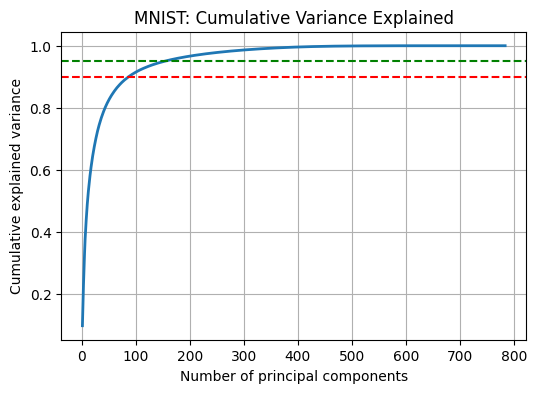

In [5]:
import matplotlib.pyplot as plt

var_ratio = pca_full.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

plt.figure(figsize = (6, 4))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, linewidth = 2)
plt.axhline(0.90, color = 'red', linestyle = '--') # 90% variance
plt.axhline(0.95, color = 'green', linestyle = '--') # 95% variance
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("MNIST: Cumulative Variance Explained")
plt.grid(True)
plt.show()

With this plot, we can find k that captures either 90% or 95% of the total variance. There will be a few differences each run because our svd_solver was set to auto, meaning it could be randomized. Although, it would barely make a difference in our output. For 90%, k would be around 100 - 150, and for 95%, k would be around 150 - 200.

Now, fit the PCA with k components

In [6]:
ks = [10, 50, 100, 200]

# store PCA models by k
pca_models = {}

for k in ks:
    pca_k = PCA(n_components = k, svd_solver = 'randomized', random_state = 42)
    pca_k.fit(X_train_centered)
    pca_models[k] = pca_k

Then, start the reconstruction process and compute the reconstruction error with the Frobenius-Norm error.

In [7]:
fro_errors = {}

for k in ks:
    # inverse‐transform to reconstruct
    Z_test_k = pca_models[k].transform(X_test_centered) # shape = (n_test, k)
    X_test_recon = pca_models[k].inverse_transform(Z_test_k) # shape = (n_test, d)

    # add back the mean and clip to [0,1] so pixel values remain valid
    X_test_recon = X_test_recon + mean_image
    X_test_recon = np.clip(X_test_recon, 0.0, 1.0)

    # compute the Frobenius norm of the difference
    diff = X_test - X_test_recon # shape = (n_test, d)
    fro_norm = np.linalg.norm(diff, ord = 'fro')

    fro_errors[k] = fro_norm

# print the errors
for k, err in fro_errors.items():
    print(f"k = {k}, Frobenius error = {err:.2f}")

k = 10, Frobenius error = 509.15
k = 50, Frobenius error = 284.01
k = 100, Frobenius error = 193.38
k = 200, Frobenius error = 118.69


From these results, we can see that as k increases, the error decreases. This makes perfect sense. If k = 10, we reduce each 784-D image to just 10 numbers. If k = 200, we keep 200 principal components, so each image becomes a 200-D vector instead of 784-D. As k grows, we keep more principal components, so we lose less information.

Let's visualize these reconstructions now.

For now, let's choose 15 random examples for visualizations.

In [8]:
def plot_images(orig, reconstructions, ks_list):
    n_cols = len(ks_list) + 1
    plt.figure(figsize=(2 * n_cols, 2))

    # original
    ax = plt.subplot(1, n_cols, 1)
    ax.imshow(orig.reshape(28, 28), cmap = "gray")
    ax.set_title("Original")
    ax.axis("off")

    # reconstructions
    for i, k in enumerate(ks_list):
        ax = plt.subplot(1, n_cols, i + 2)
        ax.imshow(reconstructions[i].reshape(28, 28), cmap = "gray")
        ax.set_title(f"k = {k}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

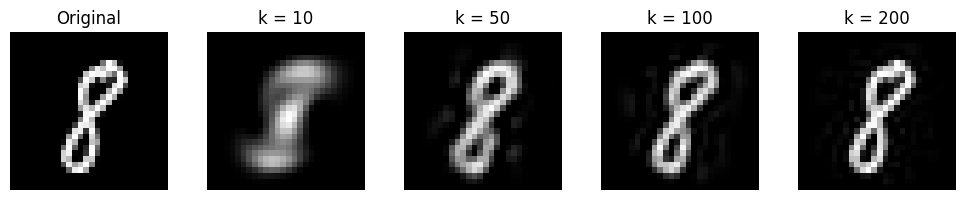

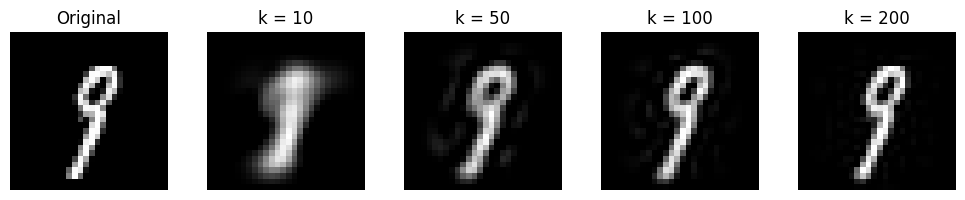

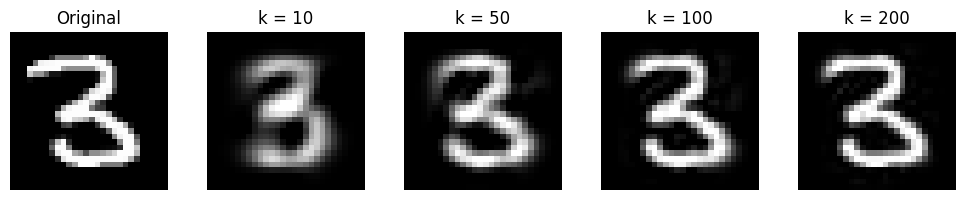

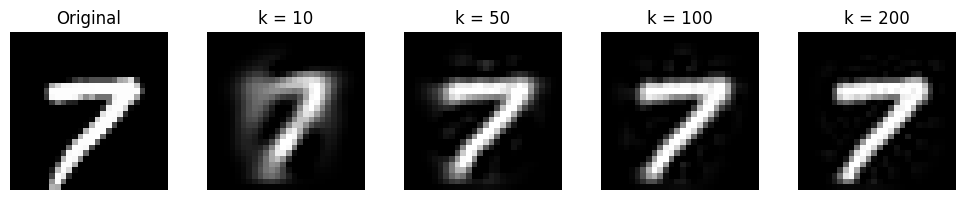

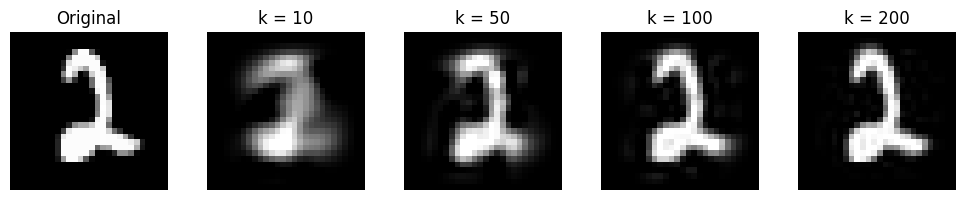

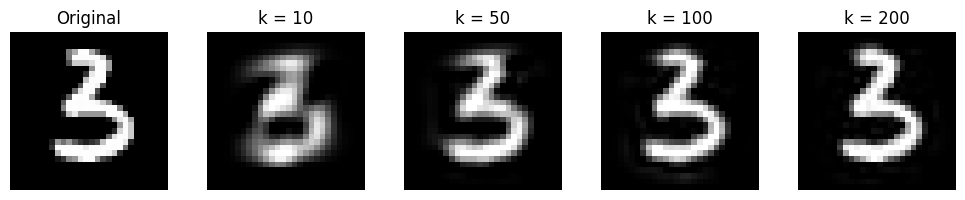

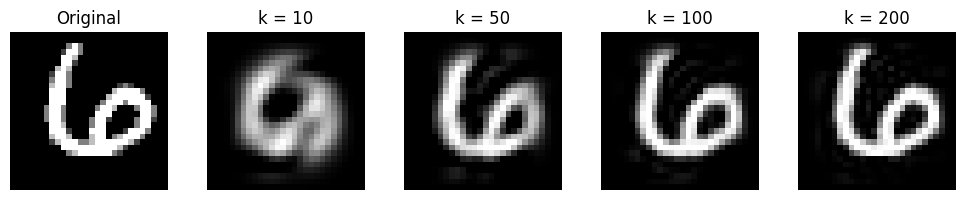

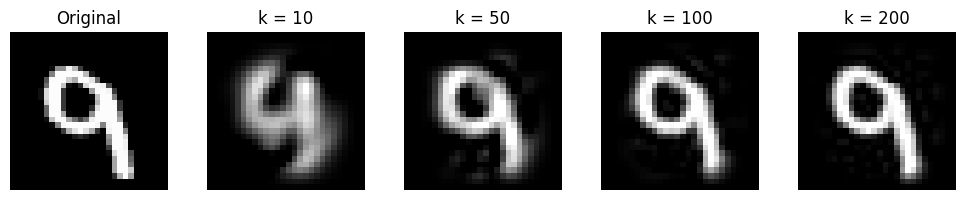

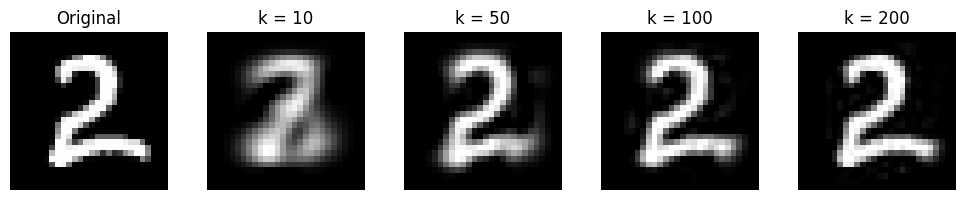

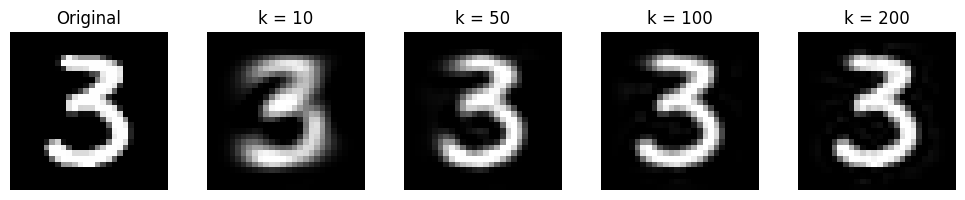

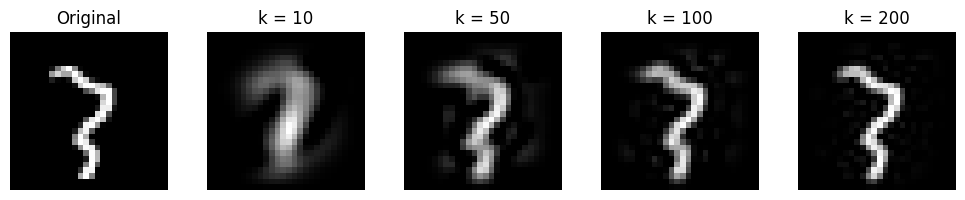

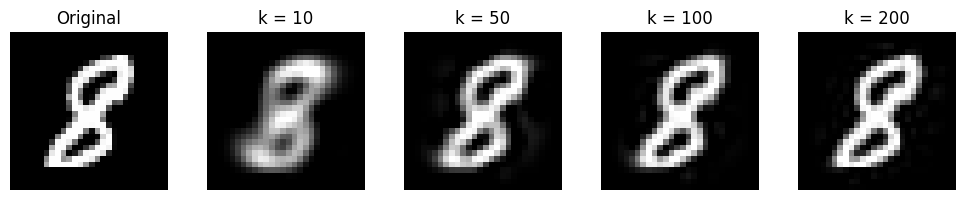

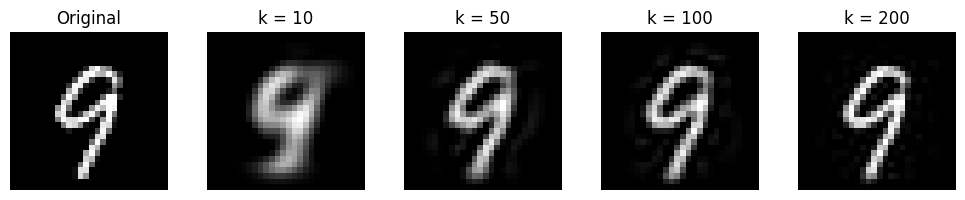

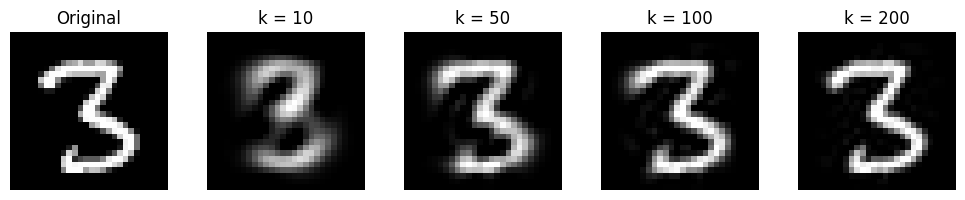

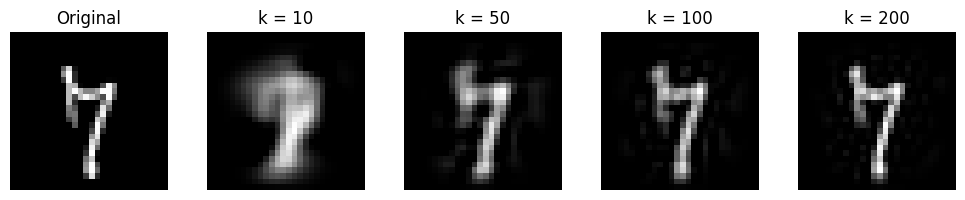

In [9]:
rng = np.random.RandomState(0)
sample_idxs = rng.choice(len(X_test_centered), size = 15, replace = False)

for idx in sample_idxs:
    orig_img = (X_test_centered[idx] + mean_image).clip(0, 1)  # shape (784,)
    recon_imgs = []
    for k in ks:
        recon_centered = pca_models[k].inverse_transform(
            pca_models[k].transform([X_test_centered[idx]])
        )[0]
        recon = (recon_centered + mean_image).clip(0, 1)
        recon_imgs.append(recon)

    plot_images(orig_img, recon_imgs, ks)

## Part 1 Takeaways:

My reconstructions clearly demonstrate that PCA can compress MNIST from 784 to k dimensions with controllable loss:

At k = 10, the error is large and digits are very blurry.

At k = 50, digits are recognizable but still blurred.

At k ≥ 100, details start to look quite good, and by k = 200 the reconstructions look nearly identical to the originals.

Conclusion: Although MNIST is not perfectly linear, it is so well-structured that a 100-200-dimensional linear subspace contains more than 90-95% of its variance. Consequently, PCA is an excellent tool for compressing MNIST-style images.

## Part 2: My PCA Implementation

Now that I know how to utilize a library's PCA, I want to implement my own PCA class and compare it to the library's PCA. The main goal of this is to further deepen my understanding of PCA.

In [10]:
class My_PCA():
    def __init__(self, X, n_components):
        # X is a data matrix of shape (n, p)
        # n_components are the number of components

        if hasattr(X, "to_numpy"):
            X = X.to_numpy()
        self.n_components = n_components
        self.X = X
        self.G, self.Z, self.mean = self._do_pca()

    def _do_pca(self):
        '''
        PCA decomposition.
        First, find X_tilde which is the centered data and apply svd on it.
        Then, find G or first k columns of U from the svd as the projection matrix.
        Last, get the projected features, Z from G.T.dot(X_tilde)

        It is worth noting that the k-th row in Z is called the k-th principal
        components (PC). Therefore, PCA achieves feature reduction by
        keeping only the first k PCs.

        Returns:
            G: Principal components (transform matrix) of shape [n_features, n_components].
            Z: The reduced data matrix after PCA of shape [n_samples, n_components].
        '''
        mean = np.mean(self.X, axis = 0)
        X_centered = self.X - mean # shape = (n, p)
        X_tilde = X_centered.T # shape = (p, n)

        U, S, Vt = np.linalg.svd(X_tilde, full_matrices = False)

        G = U[:, :self.n_components] # shape = (p, k)

        Z = G.T.dot(X_tilde) # shape = (k, n)

        return G, Z, mean

    def get_reduced(self, X = None):
        '''
        To return the reduced data matrix.
        Args:
            X: The data matrix with shape [n_any, n_features] or None.
               If None, return reduced training X.
        Returns:
            Z: The reduced data matrix of shape [n_any, n_components].
        '''
        if hasattr(X, "to_numpy"):
            X = X.to_numpy()
        if X is None:
            Zt = self.Z_tilde.T
        else:
            X_centered = X - self.mean # (n_any, p)
            X_tilde_new = X_centered.T # (p, n_any)
            Zt = self.G.T.dot(X_tilde_new)

        return Zt.T

    def reconstruction(self, Z = None):
        '''
        To reconstruct reduced data given principal components G.

        Args:
        Z: The reduced data matrix after PCA of shape [n_samples, n_components].

        Return:
        X_rec: The reconstructed matrix of shape [n_samples, n_features].
        '''
        if hasattr(Z, "to_numpy"):
            Z = Z.to_numpy()
        if Z is None:
            Z = self.get_reduced()

        Zt = Z.T
        X_tilde_rec = self.G.dot(Zt) # shape = (p, n_any)
        X_centered_rec = X_tilde_rec.T # shape = (n_any, p)
        X_rec = X_centered_rec + self.mean

        return X_rec

def reconstruct_error(A, B):
    '''
    To compute the reconstruction error.

    Return:
    error: the Frobenius norm's square of the matrix A-B. A scaler number.
    '''
    return np.linalg.norm(A - B, 'fro')

In [11]:
ks = [10, 50, 100, 200]
pca_models_2 = {}

for k in ks:
    # my PCA centers X_train and computes U_k internally.
    pca_k = My_PCA(X_train, n_components = k)
    pca_models_2[k] = pca_k

In [12]:
fro_errors_2 = {}

for k in ks:
    pca_k = pca_models_2[k]

    # get reduced coords for X_test
    Z_test = pca_k.get_reduced(X_test)

    # reconstruct back to (n_test, p)
    X_test_recon = pca_k.reconstruction(Z_test)

    # clip to [0,1]
    X_test_recon = np.clip(X_test_recon, 0.0, 1.0)

    # compute Frobenius error
    fro_norm = reconstruct_error(X_test, X_test_recon)
    fro_errors_2[k] = fro_norm

for k, err in fro_errors_2.items():
    print(f"k = {k}, Frobenius error = {err:.2f}")

k = 10, Frobenius error = 509.15
k = 50, Frobenius error = 284.03
k = 100, Frobenius error = 193.08
k = 200, Frobenius error = 118.20


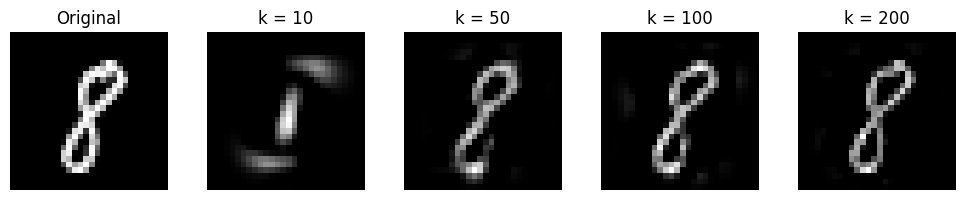

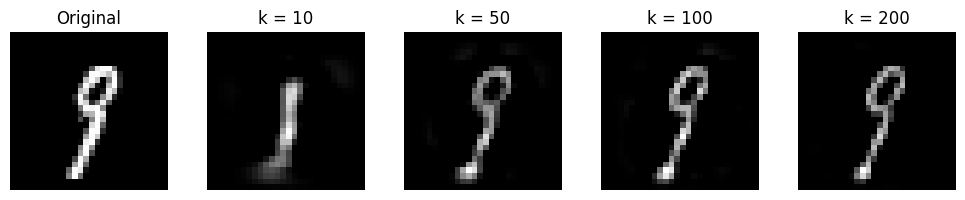

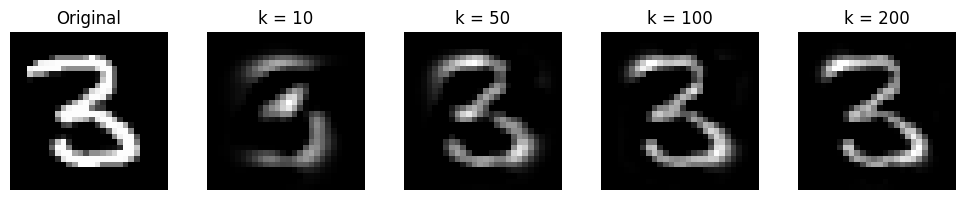

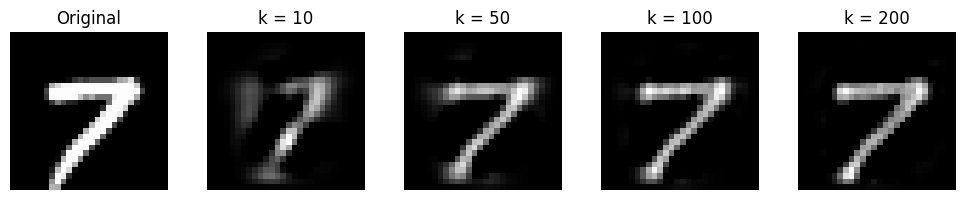

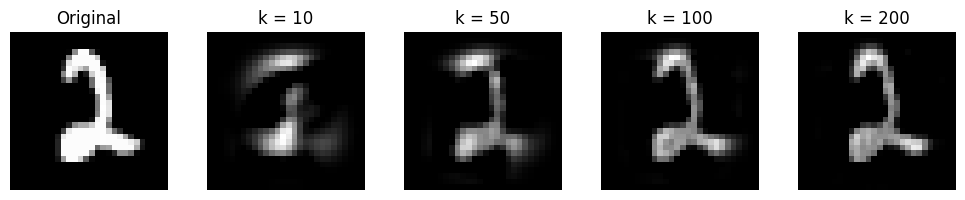

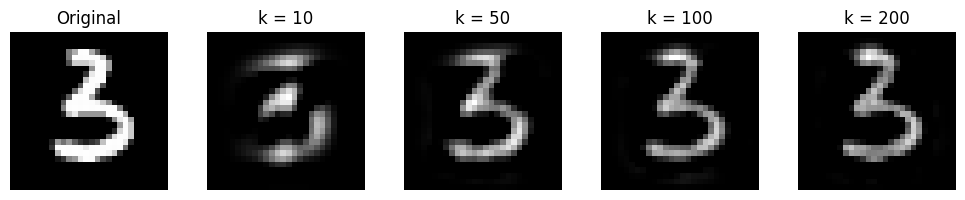

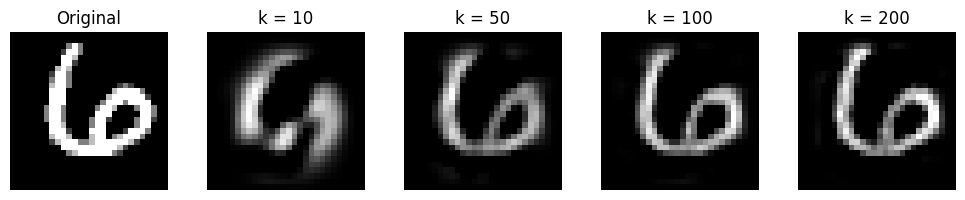

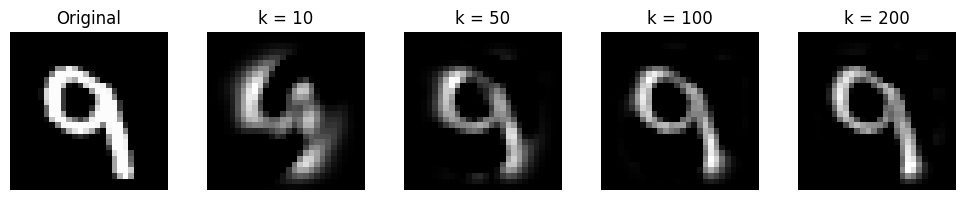

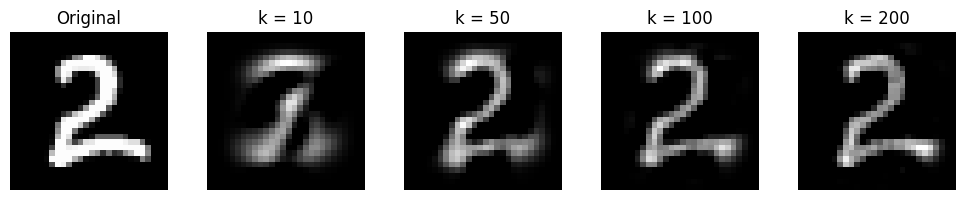

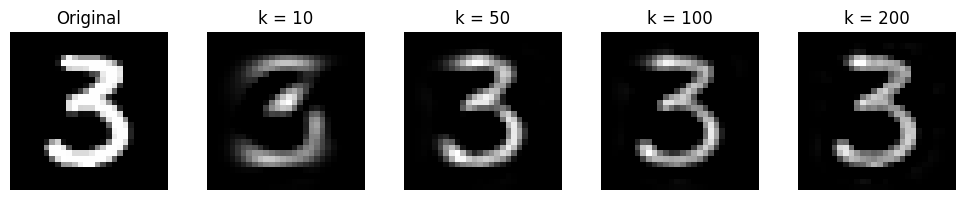

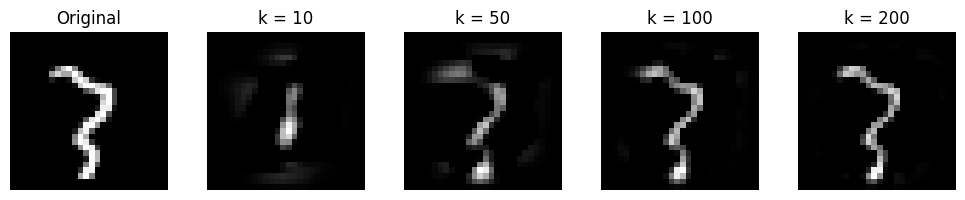

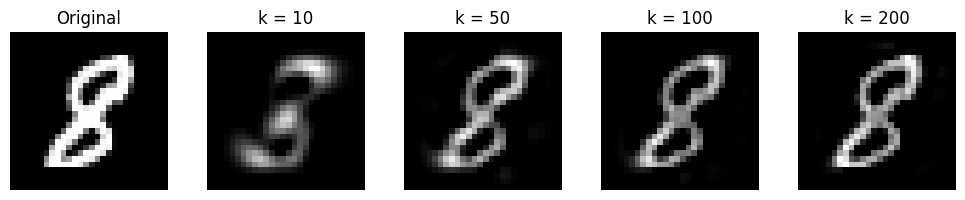

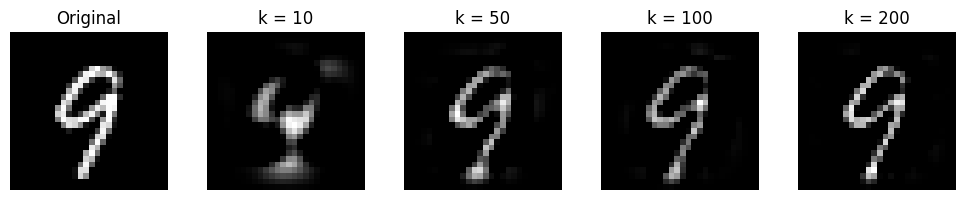

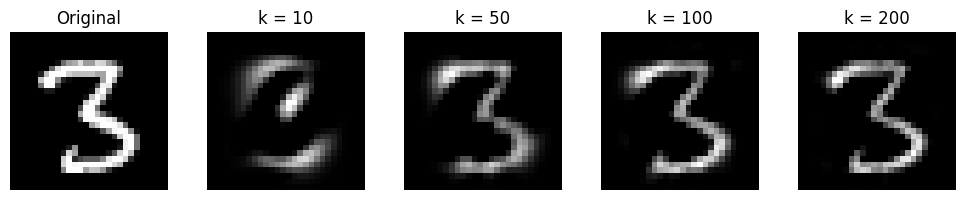

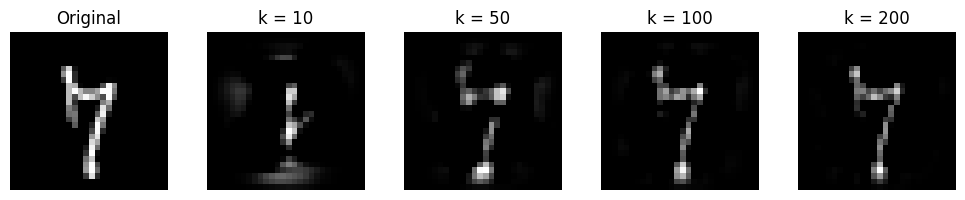

In [13]:
rng = np.random.RandomState(0)
sample_idxs = rng.choice(len(X_test_centered), size=15, replace=False)

for idx in sample_idxs:
    orig_img = (X_test_centered[idx] + mean_image).clip(0, 1)  # shape = (784,)

    recon_imgs = []
    for k in ks:
        pca_k = pca_models_2[k]

        x_centered = X_test_centered[idx : idx + 1]  # shape = (1, 784)
        Zt = pca_k.get_reduced(x_centered)  # shape = (k, 1)

        X_recon = pca_k.reconstruction(Zt)  # shape = (1, 784)

        recon_flat = X_recon[0].clip(0, 1)   # shape = (784,)
        recon_imgs.append(recon_flat)

    plot_images(orig_img, recon_imgs, ks)

## Conclusion:

From these visualizations, I can see that the results look great. Just like in Part 1,

At k = 10, the error is large and digits are very blurry.

At k = 50, digits are recognizable but still blurred.

At k ≥ 100, details start to look quite good, and by k = 200 the reconstructions look nearly identical to the originals.

The visualizations doesn't look better than the library's PCA, but it gets the job done.

Looking at the Frobenius error, the results from Part 1 and the results from Part 2 are really identical. My implmentation is off by a few decimal points.

Overall, PCA remains one of the most foundational tools for dimensionality reduction, which I was able to show in this project.